In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from datetime import datetime
import matplotlib.dates as mdates

%matplotlib inline

from AOSCMcoupling.files import OIFSPreprocessor, NEMOPreprocessor, OASISPreprocessor
plt.style.use('rc.mplstyle')

plotting_output_dir = Path(f"Plots_for_Thesis")
plotting_output_dir.mkdir(exist_ok=True, parents = True)

In [2]:
start_date = pd.Timestamp("2023-05-28")
oifs_preprocessor = OIFSPreprocessor(
    start_date, np.timedelta64(-7, "h")
)
nemo_preprocessor = NEMOPreprocessor(
    start_date, np.timedelta64(-7, "h")
)
oasis_preprocessor = OASISPreprocessor(
    start_date, np.timedelta64(-7, "h")
)

### Spreads for each location for atmosphere temperature, sea surface temperature, ice surface temperature

In [3]:
N_iterates = 30
target_longitude = 7.0
target_latitude = 81.0

target_latitudes = [80.0, 81.0]
target_longitudes = [1.0, 2.5, 4.0, 5.5, 7.0]
lon_lats = [(1.0, 79.0), (2.5, 79.0)] + [ (lon, lat) for lon in target_longitudes for lat in target_latitudes]

In [4]:
# Initial concentrations to sort locations by sea ice concentration
ece4_dir_pathsP  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/RPP/") for lon, lat in lon_lats]
Init_ice = [
    xr.open_mfdataset(
          f"{ece4_dir}/Ice_initialization.nc"
    )
    for ece4_dir in ece4_dir_pathsP 
]

# sort locations by initial concentration
init_conc = [ds['a_i'].values[0,0,0] for ds in Init_ice]
sorted_by_concentration = sorted(zip(init_conc, lon_lats), key=lambda x: x)
concentrations_sorted, lon_lats_sorted_by_conc = zip(*sorted_by_concentration)

# create paths and 
ece4_dir_paths  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/SWR") for lon, lat in lon_lats_sorted_by_conc]
def generate_sip_list(n):
    return [f"RSW_{i}" for i in range(1, n+1)]
exp_ids = generate_sip_list(N_iterates)

#concentrations_sorted

In [5]:
# load data

# openifs - progvar
oifs_progvar_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/progvar.nc", preprocess=oifs_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]
 
# nemo temperature
nemo_t_grids_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/*_T_*.nc", preprocess=nemo_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]

# ice surface temperature
Ice_temp_O_grids_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/O_TepI*.nc", preprocess=oasis_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]

/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=self.origin + time_data + self.time_shift)
/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta6

In [6]:
# compute maximum spreads for each variable
range_max_loc =np.zeros((12,3))

#10m Atmo
for d in range(len(ece4_dir_paths)):

    arrays_to_merge = [oifs_progvar_ece4[d][i].t.sel(nlev=137) - 273.15 for i in range(5,len(oifs_progvar_ece4[d]))]
    merged = xr.concat(arrays_to_merge, dim='iter')
    
    max_v = merged.max(dim = 'iter')
    min_v = merged.min(dim = 'iter')

    range_temp = max_v - min_v
    range_temp_values = range_temp.values
  
    range_max_loc[d,0] = (np.max(range_temp_values))
    
#SST
for d in range(len(ece4_dir_paths)):

    arrays_to_merge = [nemo_t_grids_ece4[d][i].sosstsst - 273.15 for i in range(5,len(nemo_t_grids_ece4[d]))]
    merged = xr.concat(arrays_to_merge, dim='iter')
    
    max_v = merged.max(dim = 'iter')
    min_v = merged.min(dim = 'iter')

    range_temp = max_v - min_v
    range_temp_values = range_temp.values

    range_max_loc[d,1] = (np.max(range_temp_values))

# IST
for d in range(len(ece4_dir_paths)):

    arrays_to_merge = [Ice_temp_O_grids_ece4[d][i] for i in range(5,len(Ice_temp_O_grids_ece4[d]))]
    merged = xr.concat(arrays_to_merge, dim='iter')
    
    max_v = merged.max(dim = 'iter')
    min_v = merged.min(dim = 'iter')

    range_temp = max_v - min_v
    range_temp_values = range_temp.values
    range_max_loc[d,2] = (np.max(range_temp_values))

In [7]:
for i, var in enumerate(['10m Temp.', 'SST', 'IST']):
    print(var, ': MIN:', np.round(min(range_max_loc[:,i]),4), 
              'MAX', np.round(max(range_max_loc[:,i]),4), 'mean:', round(np.mean(range_max_loc[:,i]),2) )

10m Temp. : MIN: 0.0245 MAX 0.6664 mean: 0.29
SST : MIN: 0.0009 MAX 0.032 mean: 0.01
IST : MIN: 0.0214 MAX 1.1961 mean: 0.63


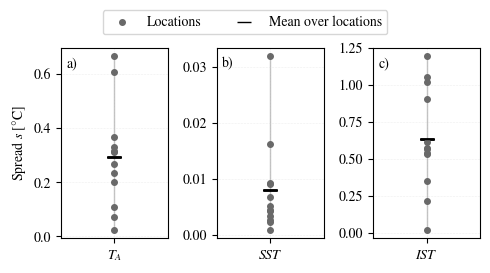

In [17]:
boxplot_data = range_max_loc.T
latex_coup_variables = [r'$T_A$', r'$SST$', r'$IST$']
fig, ax = plt.subplots(1,3, figsize=(5, 2.5), tight_layout =True)
letterlist = ['a)', 'b)', 'c)']

for k in range(3):
    meanval = np.mean(boxplot_data[k,:])
    ax[k].plot([k,k], [np.min(boxplot_data[k,:]), np.max(boxplot_data[k,:])], color='silver', lw=1, zorder=-10)
    for l in range(12):
        
        lineb7 = ax[k].scatter(k, boxplot_data[k,l], color='dimgrey', marker='o', zorder=10)
        linemean = ax[k].scatter(k, meanval, color='black', marker='_', s=100, zorder=10)

    ax[k].set_xticks([k])
    ax[k].set_xticklabels([latex_coup_variables[k]])

    ax[k].grid(True, linestyle=':', alpha=0.7)
    ax[k].text(0.05,.95,letterlist[k],transform=ax[k].transAxes,
                        ha='left',va='top')
    

lineb7.set_label(r'Locations')
linemean.set_label(r'Mean over locations')

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3)


ax[0].set_ylabel(r"Spread $s$ [°C]")

# Display the box plot
plt.tight_layout()
fig.savefig("Plots_for_Thesis/sec3_temp_plot.pdf", bbox_inches='tight')
plt.show()

### Spread for location tempoarly resolved

In [9]:
# Number iterations
N_iterates = 30

# select location
lon_lats = [(4.0, 81.0)]

ece4_dir_paths  = [Path(f"output_control_experiment_50_iter/lon_{lon}_lat_{lat}/SWR") for lon, lat in lon_lats]
def generate_sip_list(n):
    return [f"RSW_{i}" for i in range(1, n+1)]
exp_ids = generate_sip_list(N_iterates)

In [10]:
# load data for the given variable
oifs_progvar_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/progvar.nc", preprocess=oifs_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]

nemo_t_grids_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/*_T_*.nc", preprocess=nemo_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]

Ice_temp_O_grids_ece4 = [[
    xr.open_mfdataset(
        f"{ece4_dir}/{exp_id}/O_TepI*.nc", preprocess=oasis_preprocessor.preprocess
    )
    for exp_id in exp_ids
] for ece4_dir in ece4_dir_paths]


/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = ds.assign_coords(time=self.origin + time_data + self.time_shift)
/home/an0104ro/ece4/lib/python3.11/site-packages/AOSCMcoupling/files.py:240: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta6

In [11]:
#Plot iterations in dependence of time and ocilations at one time point
letterarray = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']

alpha = 1/N_iterates
alphas = np.linspace(alpha,1,N_iterates)

color = "black"

color_P = 'chocolate'
linestyle_P = '--'
zorder_P = 100

In [12]:
# Initialize dictionaries to store results
max_ranges = {}  
max_range_times = {} 

# Loop through the variables
variables = ["10m Temp.", "SST", "IST"]
datasets = [oifs_progvar_ece4, nemo_t_grids_ece4, Ice_temp_O_grids_ece4]

#
for var, dataset_group in zip(variables, datasets):
    # Initialize empty lists for storing results for each variable
    max_ranges[var] = []
    max_range_times[var] = []

    combined = None
    for i in range(5,len(alphas)):
        data = dataset_group[0][i]
        if var == "10m Temp.":
            time_series = data.t.sel(nlev=137) - 273.15
        elif var == "SST":
            time_series = data.sosstsst
        elif var == "IST":
            time_series = data - 273.15

        # Combine along a new dimension if not already done
        combined = xr.concat([combined, time_series], dim="iteration") if combined is not None else time_series

    # Calculate the range (max - min) 
    range_per_time = combined.max(dim="iteration") - combined.min(dim="iteration")
    range_per_time = range_per_time.compute() 
    
    # Find the maximum range and corresponding time
    max_ranges[var].append(range_per_time.max())  
    
    max_range_times[var].append(range_per_time.time[range_per_time.argmax()].values)  

# Display the results
for var in variables:
    print(f"{var}:")
    for d, (range_val, range_time) in enumerate(zip(max_ranges[var], max_range_times[var])):
        print(f"  Location {d+1}: Maximum range = {range_val:.4f}, at time = {pd.Timestamp(range_time)}")

10m Temp.:
  Location 1: Maximum range = 0.2696, at time = 2023-05-28 21:24:00
SST:
  Location 1: Maximum range = 0.0091, at time = 2023-05-28 22:15:00
IST:
  Location 1: Maximum range = 0.5407, at time = 2023-05-28 19:00:00


DatetimeIndex(['2023-05-28 21:24:00'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2023-05-28 22:15:00'], dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2023-05-28 19:00:00'], dtype='datetime64[ns]', freq=None)


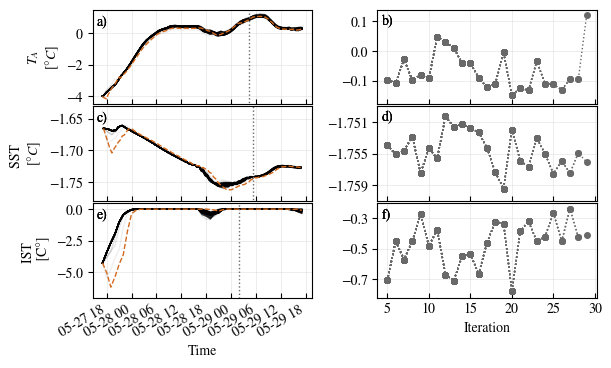

In [13]:
# Plot iterations in dependence
fig, axs = plt.subplots(nrows=3, ncols = 2, figsize = (6, 4), sharex = 'col', sharey = False)  
axs=np.atleast_2d(axs)

# 10 m Atmo
ax = axs[0][0]
for i in range(0,len(alphas)):

    oifs_progvar = oifs_progvar_ece4[0][i]

    if i == 0:
        (oifs_progvar.t.sel(nlev=137) - 273.15).plot(ax = ax, color=color_P, linestyle = linestyle_P, zorder=zorder_P)
    else:
        (oifs_progvar.t.sel(nlev=137) - 273.15).plot(
            ax = ax,
            alpha=alphas[i],
            color = color
        )
ax.set_ylabel("$T_A$ \n$[°C]$")
ax.set_xlabel(None)
ax.set_title(None)

# SST
ax = axs[1][0]
for i in range(len(alphas)):
    nemo_t = nemo_t_grids_ece4[0][i]  

    if i == 0:
        nemo_t.sosstsst.plot(ax = ax, color=color_P, linestyle = linestyle_P, zorder=zorder_P)
    else:
        nemo_t.sosstsst.plot(
            ax = ax,  
            color=color,
            alpha=alphas[i],
        )

ax.set_ylabel("SST \n$[°C]$")
ax.set_title(None)

# IST
ax = axs[2][0]
for i in range(len(alphas)):
    nemo_ist = Ice_temp_O_grids_ece4[0][i]
    if i == 0:
        (nemo_ist-273.15).plot(ax = ax, color=color_P, linestyle = linestyle_P, zorder=zorder_P)
    else:
      
        (nemo_ist-273.15).plot(
            ax = ax,  
            color=color,
            alpha=alphas[i],
        )
ax.set_ylabel(f"IST \n [C°]")
ax.set_xlabel("Time")
ax.set_title(None)


# Plot oczilations
color_oszi = ['dimgrey', 'darkgrey']
line_style = [':', "--"]

for idx, var in enumerate(variables):

    ax = axs[idx][1]
    dataset_group = datasets[idx]
    max_time = pd.to_datetime(max_range_times[var])
    iterations = []
    print(max_time)
    
    # Extract the value at max range time for this location
    combined = None
    for i in range(len(alphas)):
        data = dataset_group[0][i]
        if var == "10m Temp.":
            time_series = data.t.sel(nlev=137, time= max_time) - 273.15
        elif var == "SST":
            time_series = data.sosstsst.sel(time = max_time)
        elif var == "IST":
            time_series = (data - 273.15).sel(time = max_time)
            
        iterations = np.append(iterations,time_series.values)
        ax.plot(range(len(iterations))[5:], iterations[5:], linestyle = line_style[d], color = color_oszi[d], marker='o', label=f'{lon_lats[d]}, {max_time}')
    
    ax.set_xlabel(r'Iteration $k$')

    for i, ax in enumerate(axs.flatten()):
        ax.tick_params(axis='x', direction = 'in')  # Rotating x-axis labels
        ax.ticklabel_format(axis='y',useOffset=False)
        ax.text(0.02,.95,letterarray[i],transform=ax.transAxes,
                        ha='left',va='top')

    axs[idx][1].set_xticks([5,10,15,20,25,30])
    axs[1][1].set_yticks([-1.759,-1.755, -1.751])
    axs[2][1].set_yticks([-0.3,-0.5,-0.7])

    axs[0,1].set_ylim(-0.18, 0.14)
    axs[1,1].set_ylim(-1.761, -1.749)
    axs[2,1].set_ylim(-0.82, -0.2)

# List of regular date strings
dates = [
    '2023-05-29 04:24:00',
    '2023-05-29 05:15:00',
    '2023-05-29 02:00:00'
]

# Convert strings to datetime objects
datetime_objects = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in dates]
matplotlib_dates = [mdates.date2num(dt) for dt in datetime_objects]

# Plot max ranges
axs[0,0].set_ylim(-4.5, 1.5)
axs[1,0].set_ylim(-1.78, -1.63)
axs[2,0].set_ylim(-7, 0.5)

axs[0,0].plot([matplotlib_dates[0],matplotlib_dates[0]], [-10,10], color='dimgrey', linestyle=':')
axs[1,0].plot([matplotlib_dates[1],matplotlib_dates[1]], [-10,10], color='dimgrey', linestyle=':')
axs[2,0].plot([matplotlib_dates[2],matplotlib_dates[2]], [-10,10], color='dimgrey', linestyle=':')

fig.subplots_adjust(hspace=0.02, wspace = 0.3)

# Save figure
fig.savefig(plotting_output_dir / "ece4_progvars_oifs_temps.pdf", bbox_inches = 'tight')